In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_curve, auc, ConfusionMatrixDisplay
)
from imblearn.combine import SMOTEENN
from collections import Counter
import pickle
import plotly.express as px

# Configurations
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline


In [5]:
# Load the dataset
data=pd.read_csv('preprocessed_labeled_data.csv')
data.head()

Unnamed: 0 parent_asin  review_count  average_uppercase_count  \
0           0  B00YQ6X8EO           101                 1.445545   
1           1  B081TJ8YS3            13                 4.000000   
2           2  B097R46CSY            27                 0.962963   
3           3  B08BZ63GMJ             3                 0.000000   
4           4  B00R8DXL44            11                 2.636364   

   average_review_length  Group_Time  avg_upvotes  avg_sentiment  \
0              34.594059        2583     0.980198       0.597738   
1              68.076923         268     3.769231       0.874300   
2              23.481481        1379     1.259259       0.398344   
3               6.666667         102     0.000000       0.595633   
4              33.363636        1913     0.636364       0.172336   

   verified_true_count  total_reviews  verified_purchase_ratio  mean_rating  \
0                   97            101                 0.960396     3.841584   
1                   13             13                 1.000000     3.923077   
2                   26             27                 0.962963     3.666667   
3                    3              3                 1.000000     5.000000   
4                   10             11                 0.909091     3.181818   

   rating_deviation majority_extremist  
0          1.322223           moderate  
1          1.183432          extremist  
2          1.530864           moderate  
3          0.000000           moderate  
4          1.471074           moderate

# drop Unnamed: 0 column

In [6]:
data=data.drop(['Unnamed: 0'],axis=1)

# checking missing value percentage of all the features

<Axes: >

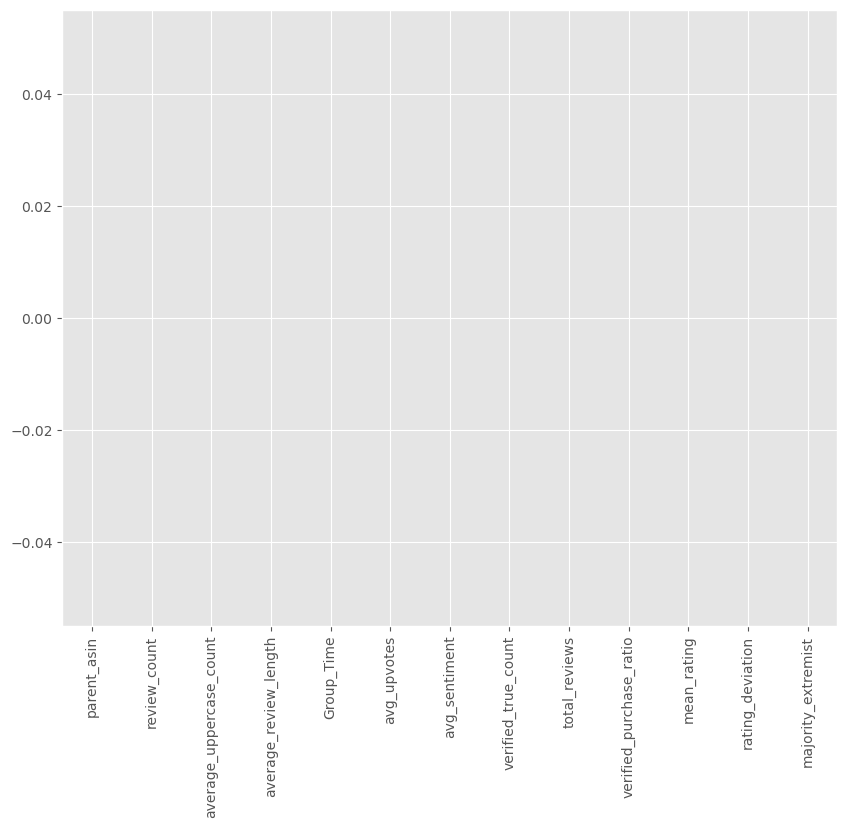

In [7]:
Miss_val = data.isna().sum()/data.shape[0]
Miss_val.sort_values(ascending=False, inplace=True)
Miss_val
plt.figure(figsize=(10,8))
Miss_val.plot.bar()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45125 entries, 0 to 45124
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   parent_asin              45125 non-null  object 
 1   review_count             45125 non-null  int64  
 2   average_uppercase_count  45125 non-null  float64
 3   average_review_length    45125 non-null  float64
 4   Group_Time               45125 non-null  int64  
 5   avg_upvotes              45125 non-null  float64
 6   avg_sentiment            45125 non-null  float64
 7   verified_true_count      45125 non-null  int64  
 8   total_reviews            45125 non-null  int64  
 9   verified_purchase_ratio  45125 non-null  float64
 10  mean_rating              45125 non-null  float64
 11  rating_deviation         45125 non-null  float64
 12  majority_extremist       45125 non-null  object 
dtypes: float64(7), int64(4), object(2)
memory usage: 4.5+ MB


# Exploratory data analysis

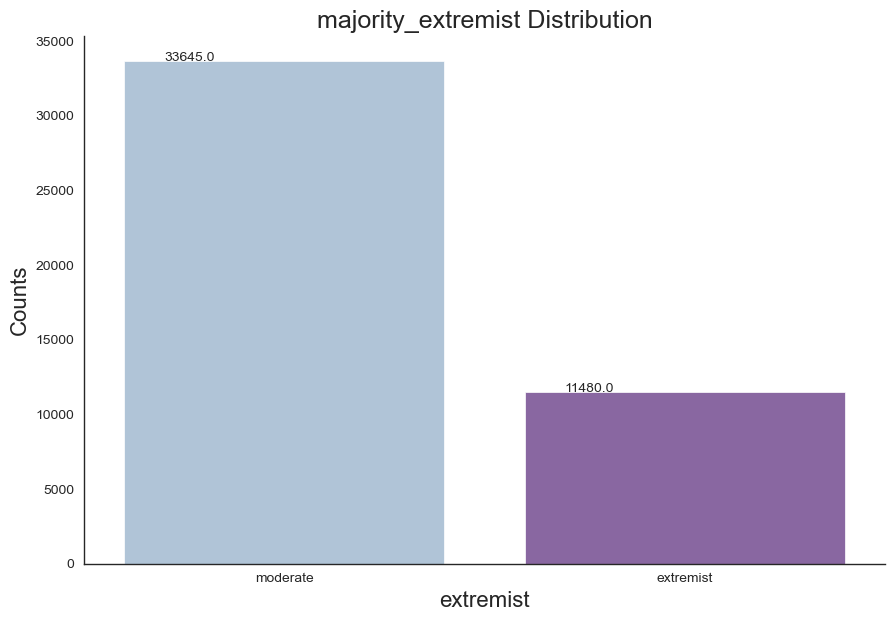

In [9]:
sns.set_style("white")
g = sns.catplot(x="majority_extremist", data=data, kind="count",
                   palette="BuPu", height=6, aspect=1.5)
g.ax.xaxis.set_label_text("extremist",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Counts", fontdict= {'size':16})
g.ax.set_title("majority_extremist Distribution",fontdict= {'size':18})
# to get the counts on the top heads of the bar
for p in g.ax.patches:
    g.ax.annotate((p.get_height()), (p.get_x()+0.1, p.get_height()+20))

# Observation:
        dataset is imbalanced

In [10]:
#selecting numeric features for analysis
num=data.select_dtypes(include=np.number)

# heatmap correlation plot

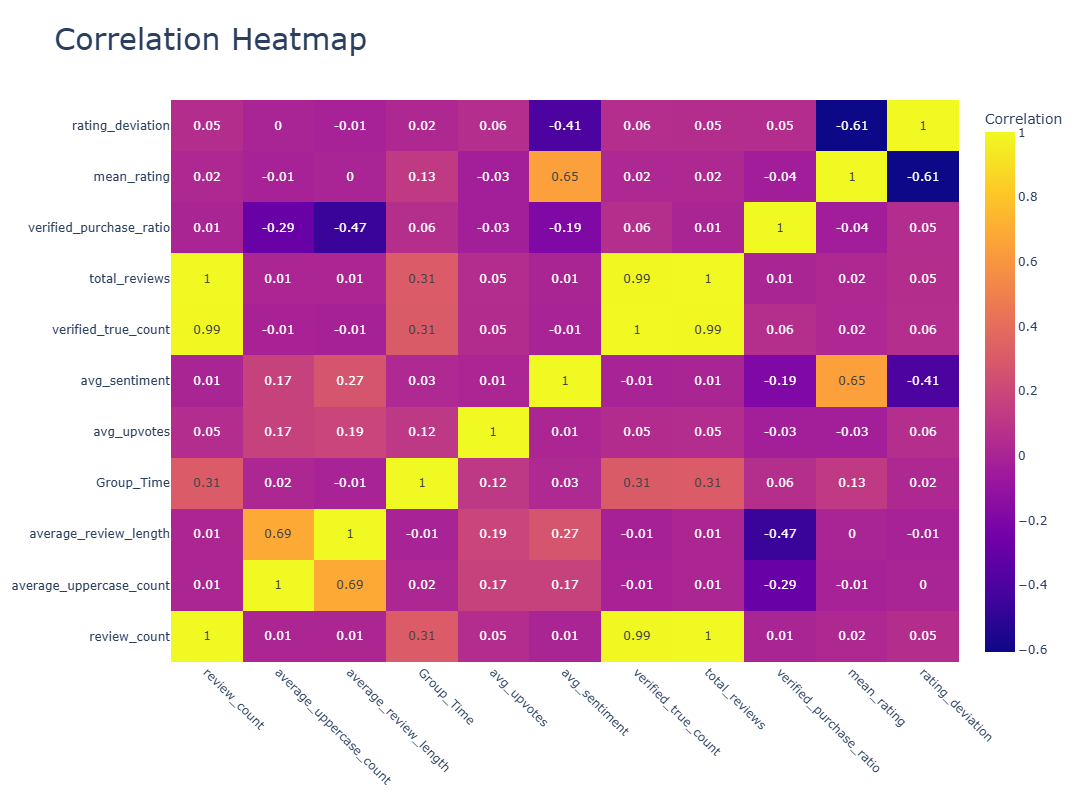

In [11]:
import plotly.express as px
import plotly.graph_objects as go


corr = num.corr()

# Create a heatmap using Plotly
fig = go.Figure(
    data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.index,
        colorscale="plasma",
        colorbar=dict(title="Correlation"),
        text=corr.values.round(2),  # Add text for correlation values (rounded for clarity)
        hoverinfo="text"  # Ensure the hover displays the tex
    )
)

# Update layout for the title and size
fig.update_traces(texttemplate="%{text}", textfont={"size": 12})  # Display text on heatmap
fig.update_layout(
    title="Correlation Heatmap",
    title_font_size=30,
    xaxis=dict(tickangle=45),
    yaxis=dict(tickangle=0),
    width=800,
    height=800
)

# Show the plot
fig.show()


# scatter plot of review_count and total_reviews

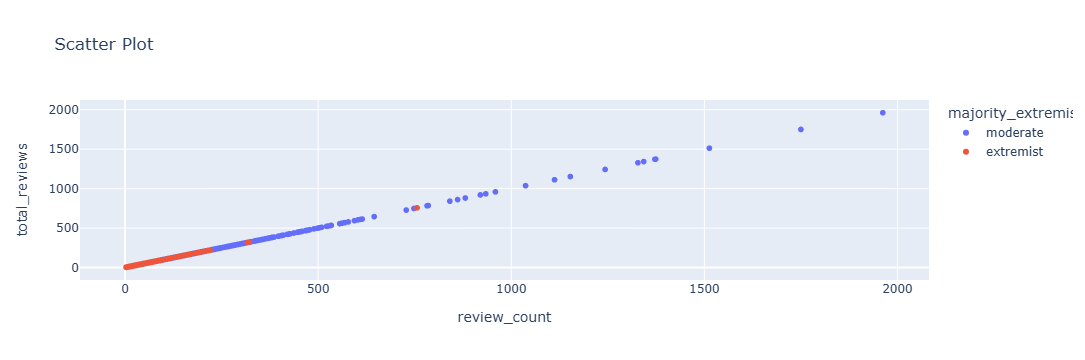

In [12]:
# Create scatter plot
fig = px.scatter(
    data,
    x='review_count',
    y='total_reviews',
    color='majority_extremist',
    title='Scatter Plot ',
    labels={'x': 'review_count', 'y': 'total_reviews'},
    
    
)

# Show the plot
fig.show()

# scatter plot of verified_true_count and total_reviews 

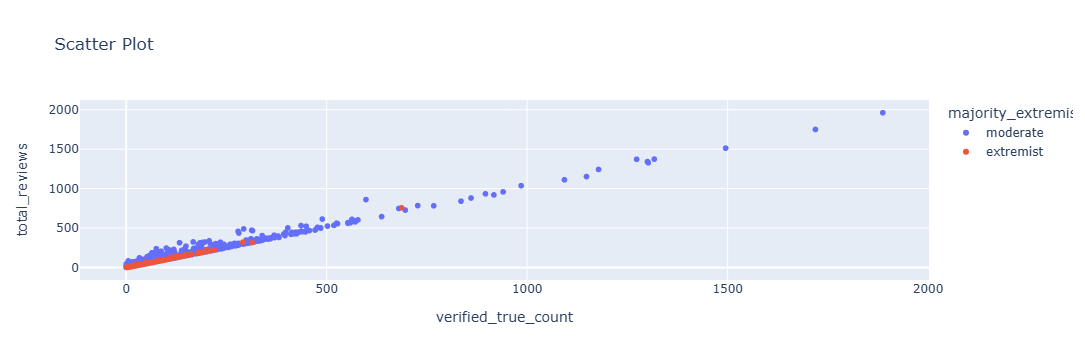

In [13]:
# Create scatter plot
fig = px.scatter(
    data,
    x='verified_true_count',
    y='total_reviews',
    color='majority_extremist',
    title='Scatter Plot ',
    labels={'x': 'verified_true_count', 'y': 'total_reviews'},
    
    
)

# Show the plot
fig.show()

# Visualizing Numerical Features with Class-Based Distribution Analysis

In [14]:
def plot_numeric(data, numeric_features, target) :
    """
    plots analysing numerical features
    Inputs :
        data -- dataframe containing features to plot
        numeric_features -- list of numerical features
        target -- target column name
     """
    # Looping through and Plotting Numeric features
    for column in numeric_features:
        # Figure initiation
        fig = plt.figure(figsize=(18,12))

        ### Distribution plot
        sns.distplot(data[column], ax=plt.subplot(221));
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel('Density', fontsize=14);
        # Adding Super Title (One for a whole figure)
        plt.suptitle('Plots for '+column, fontsize=18);

        ### Distribution per Positive / Negative class Value
     
        classes = data[target].unique()
        sns.distplot(data.loc[data[target]==classes[0], column].dropna(),
                     color='red', label=str(classes[0]), ax=plt.subplot(222));
      
        sns.distplot(data.loc[data[target]==classes[1], column].dropna(),
                     color='blue', label=str(classes[1]), ax=plt.subplot(222));
        # Adding Legend
        plt.legend(loc='best')
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel('Density per '+ str(classes[0])+' / '+str(classes[1]), fontsize=14);

        ### Average Column value per positive / Negative Value
        sns.barplot(x=target, y=column, data=data, ax=plt.subplot(223));
        # X-axis Label
        plt.xlabel('Distribution of Class Label', fontsize=14);
        # Y-axis Label
        plt.ylabel('Average ' + column, fontsize=14);

        ### Boxplot of Column per Positive / Negative class Value
        sns.boxplot(x=target, y=column, data=data, ax=plt.subplot(224));
        # X-axis Label
        plt.xlabel('Distribution of Class Label', fontsize=14);
        # Y-axis Label
        plt.ylabel(column, fontsize=14);
        # Printing Chart
        plt.show()

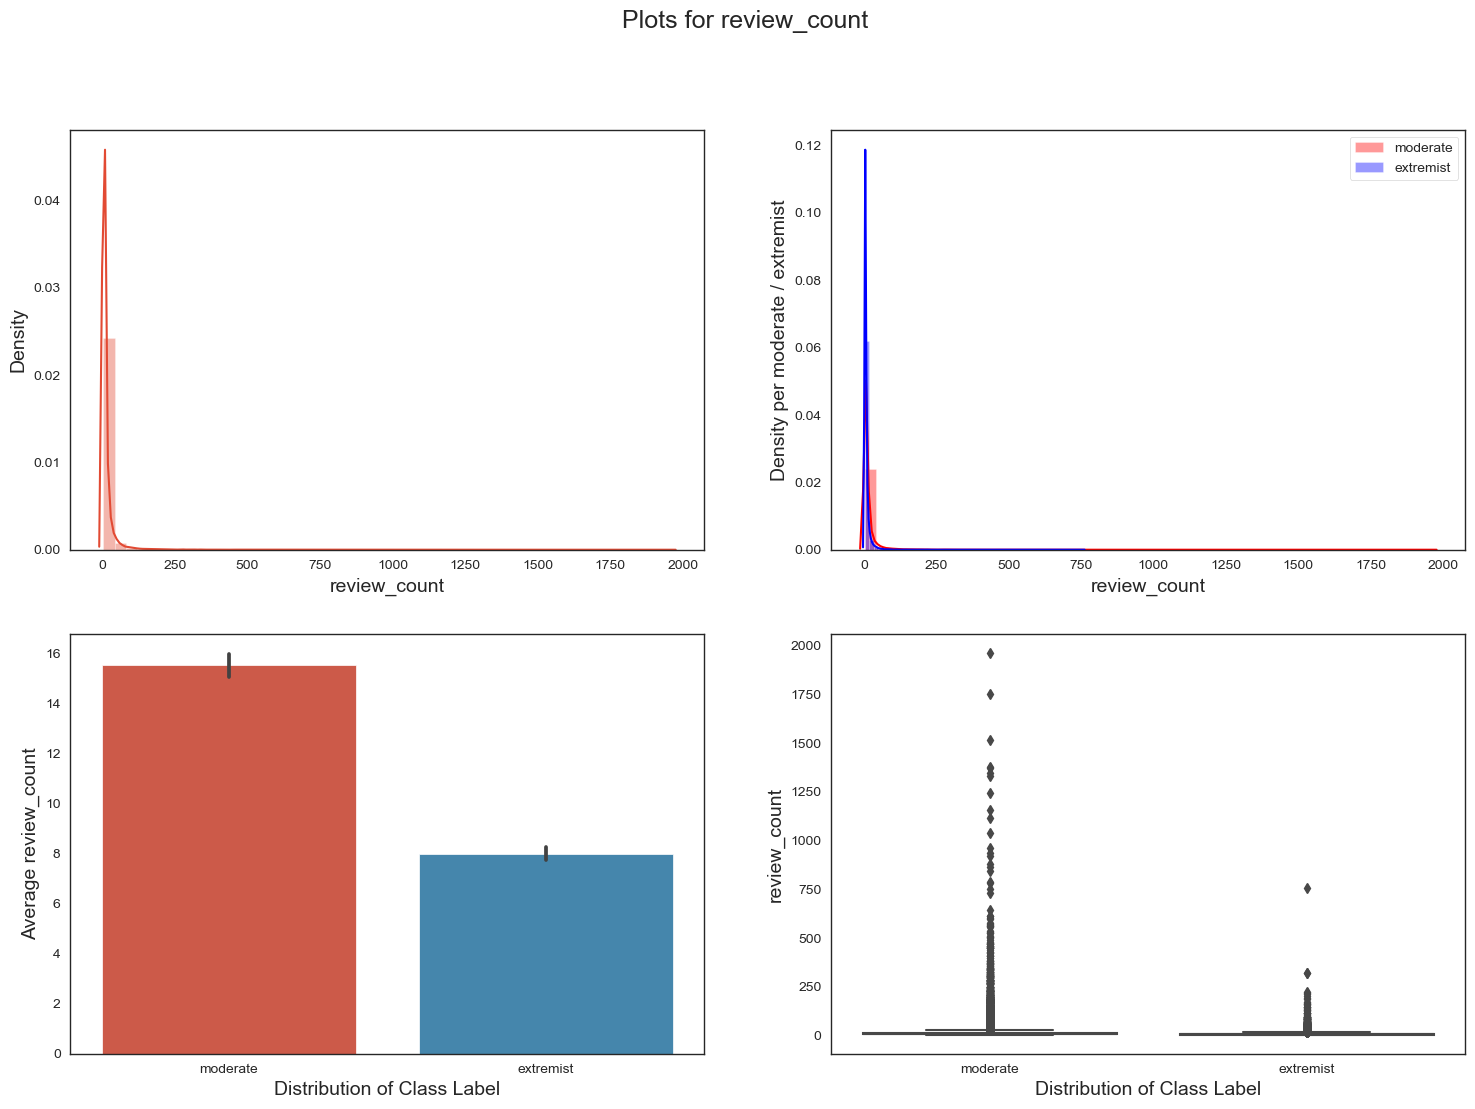

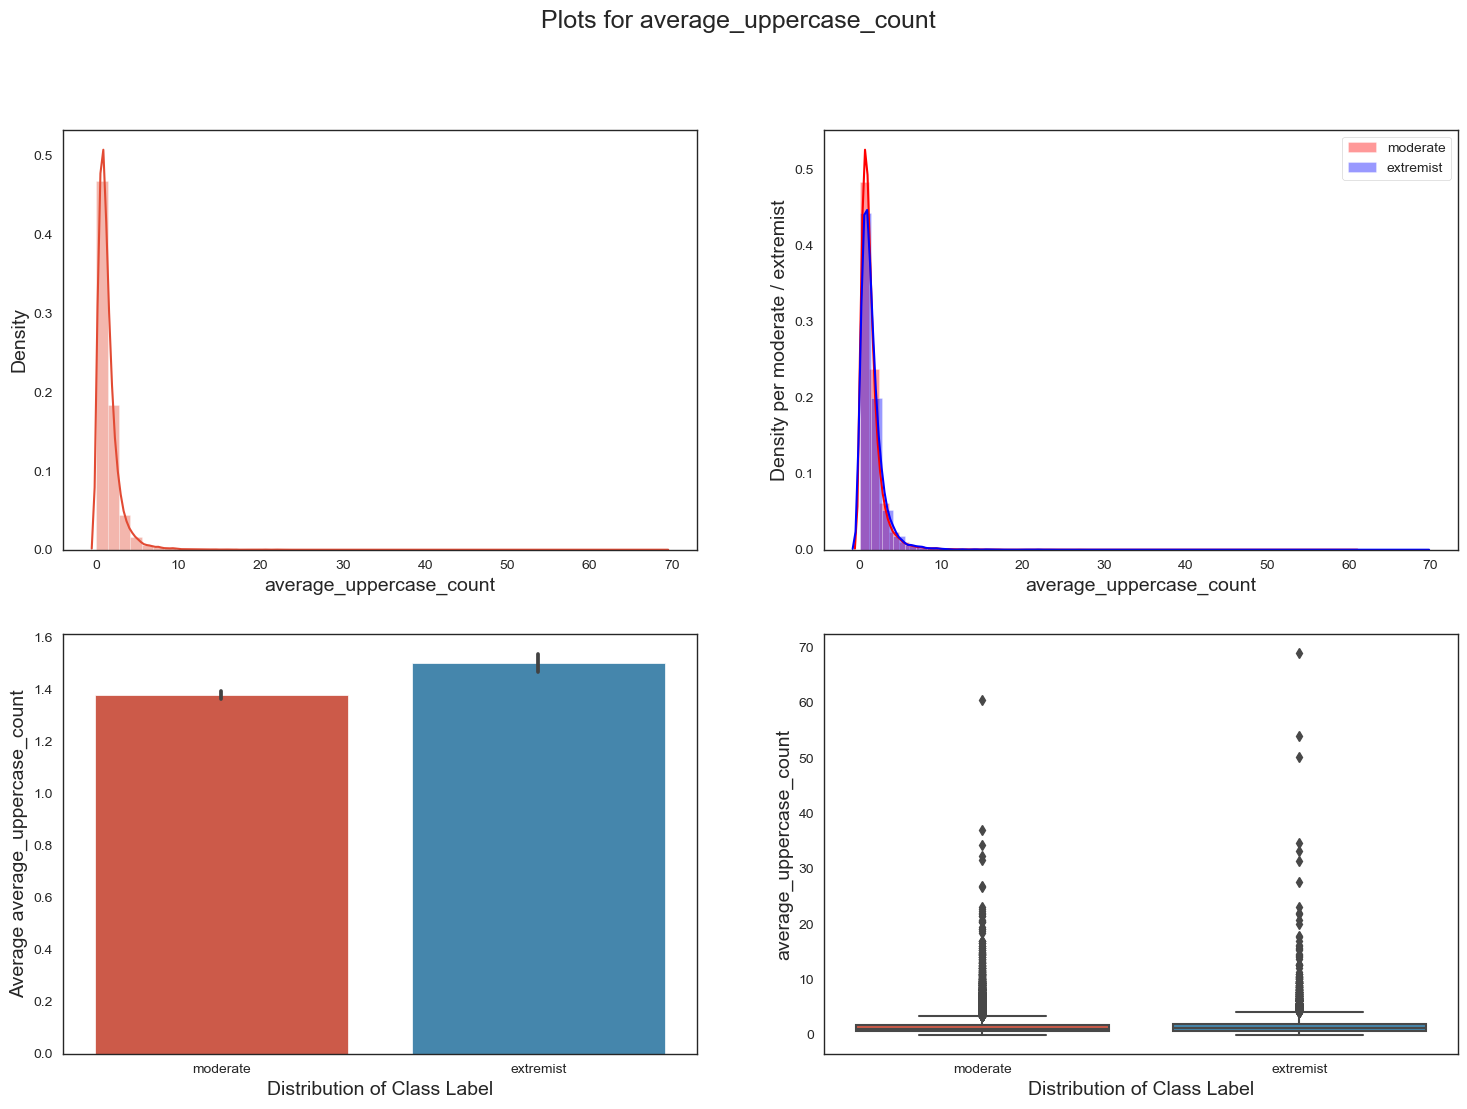

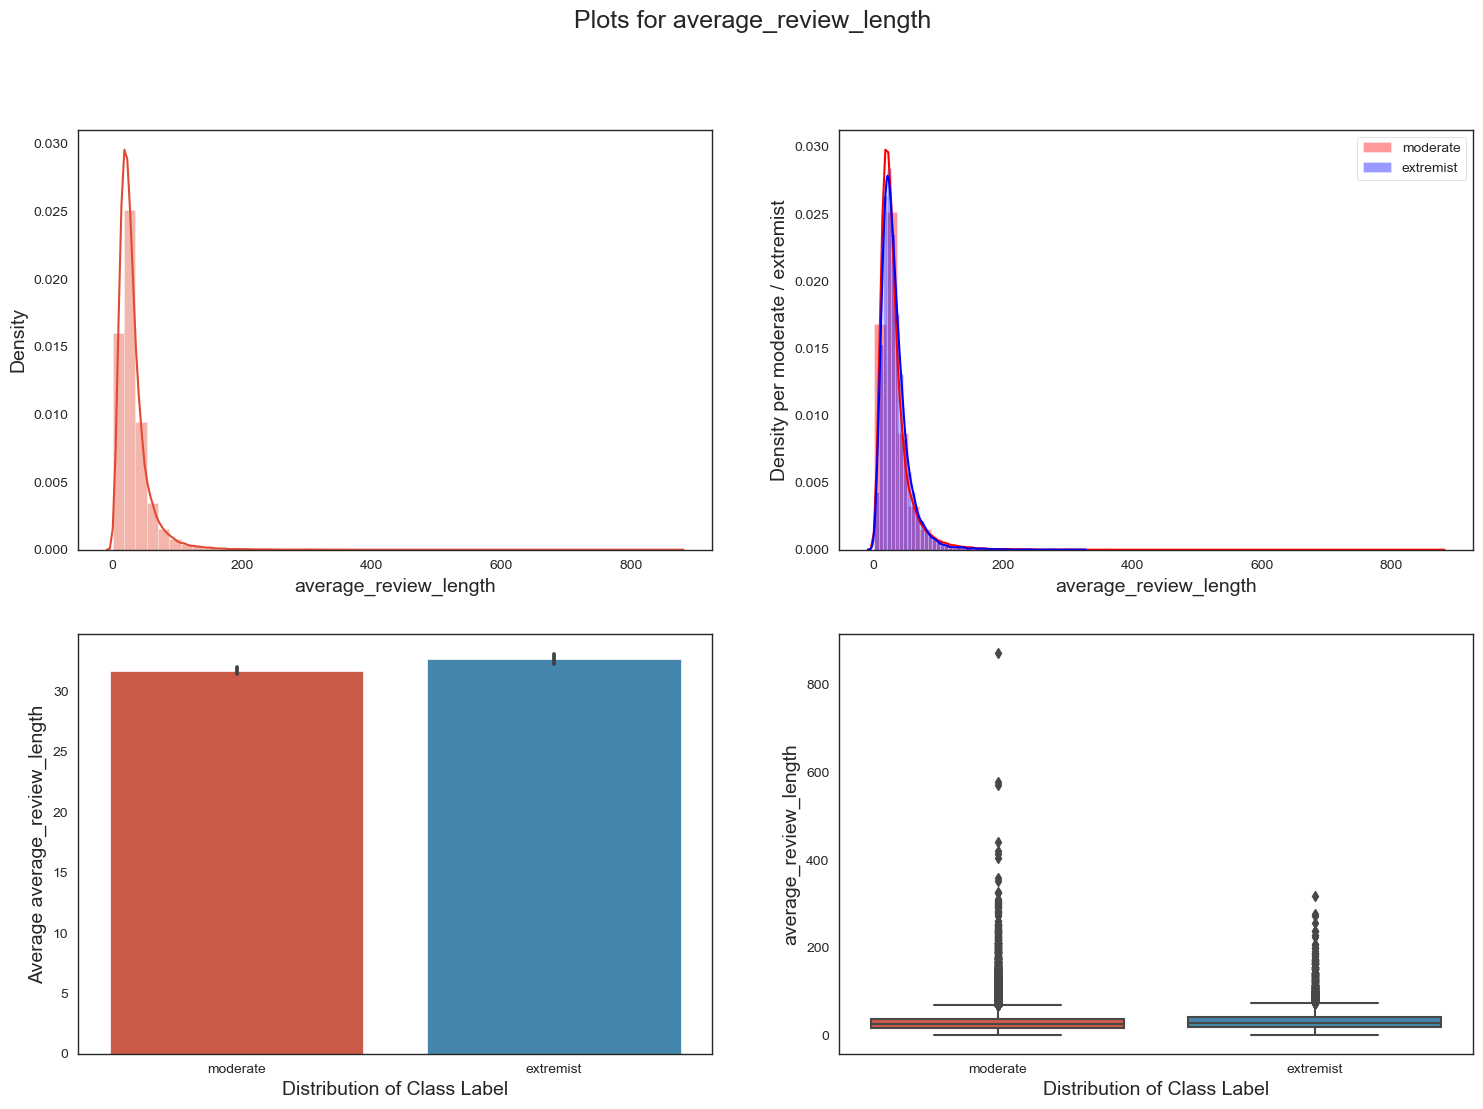

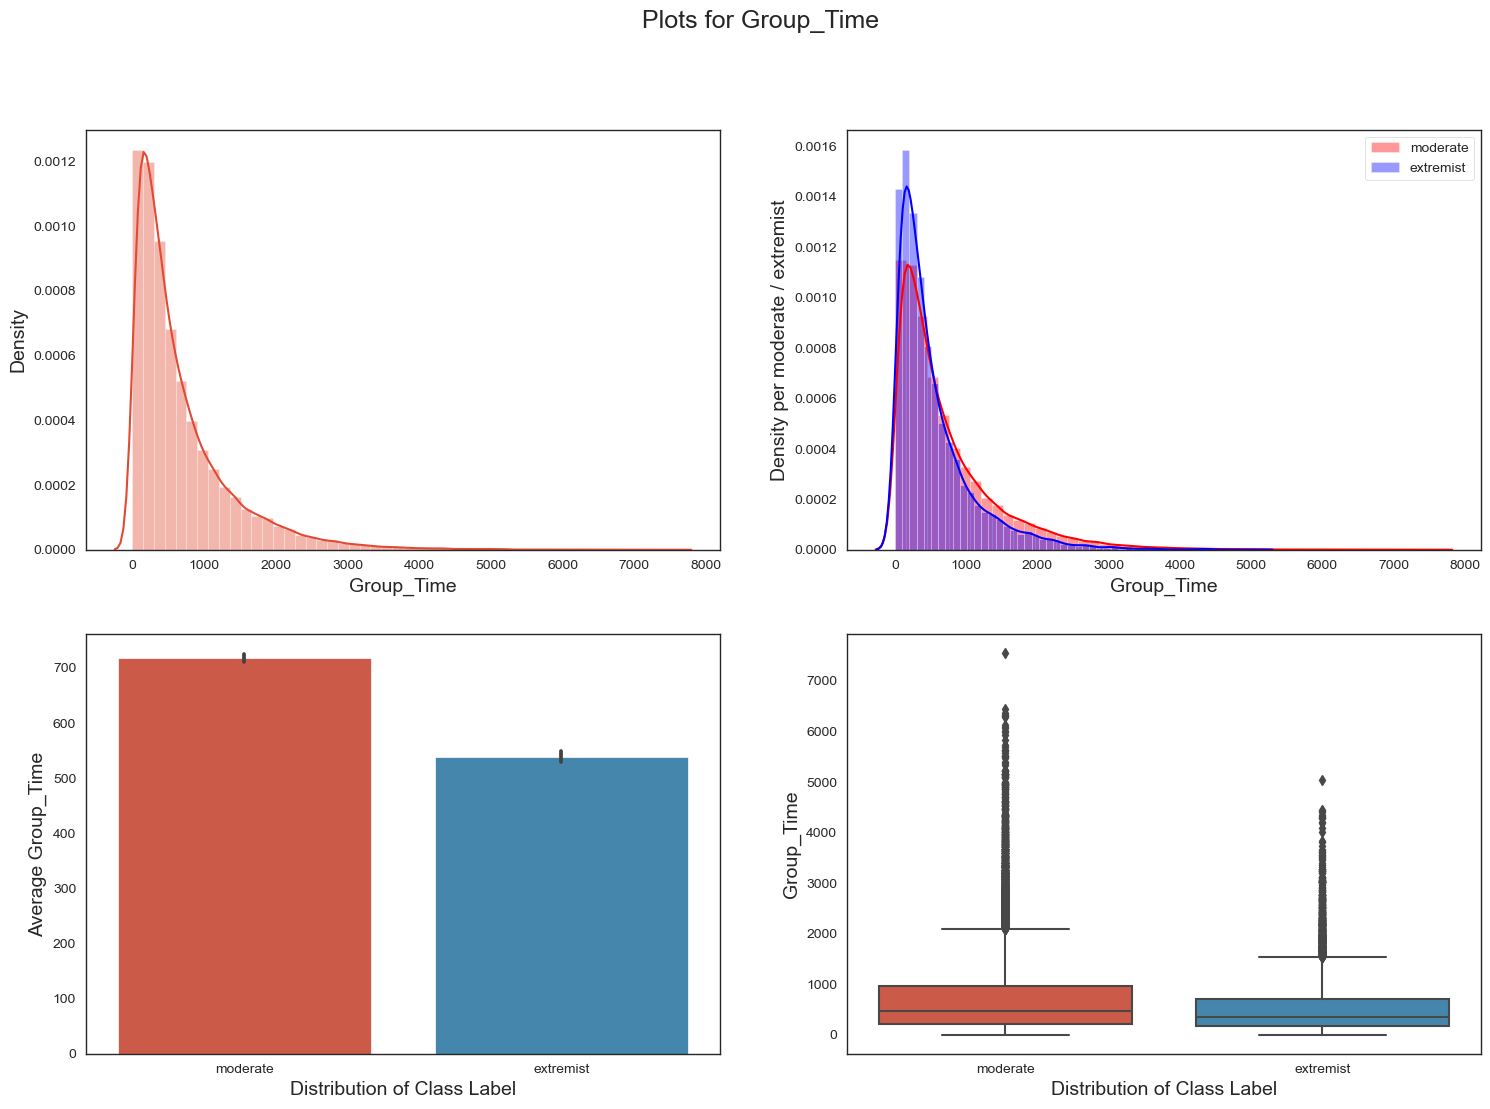

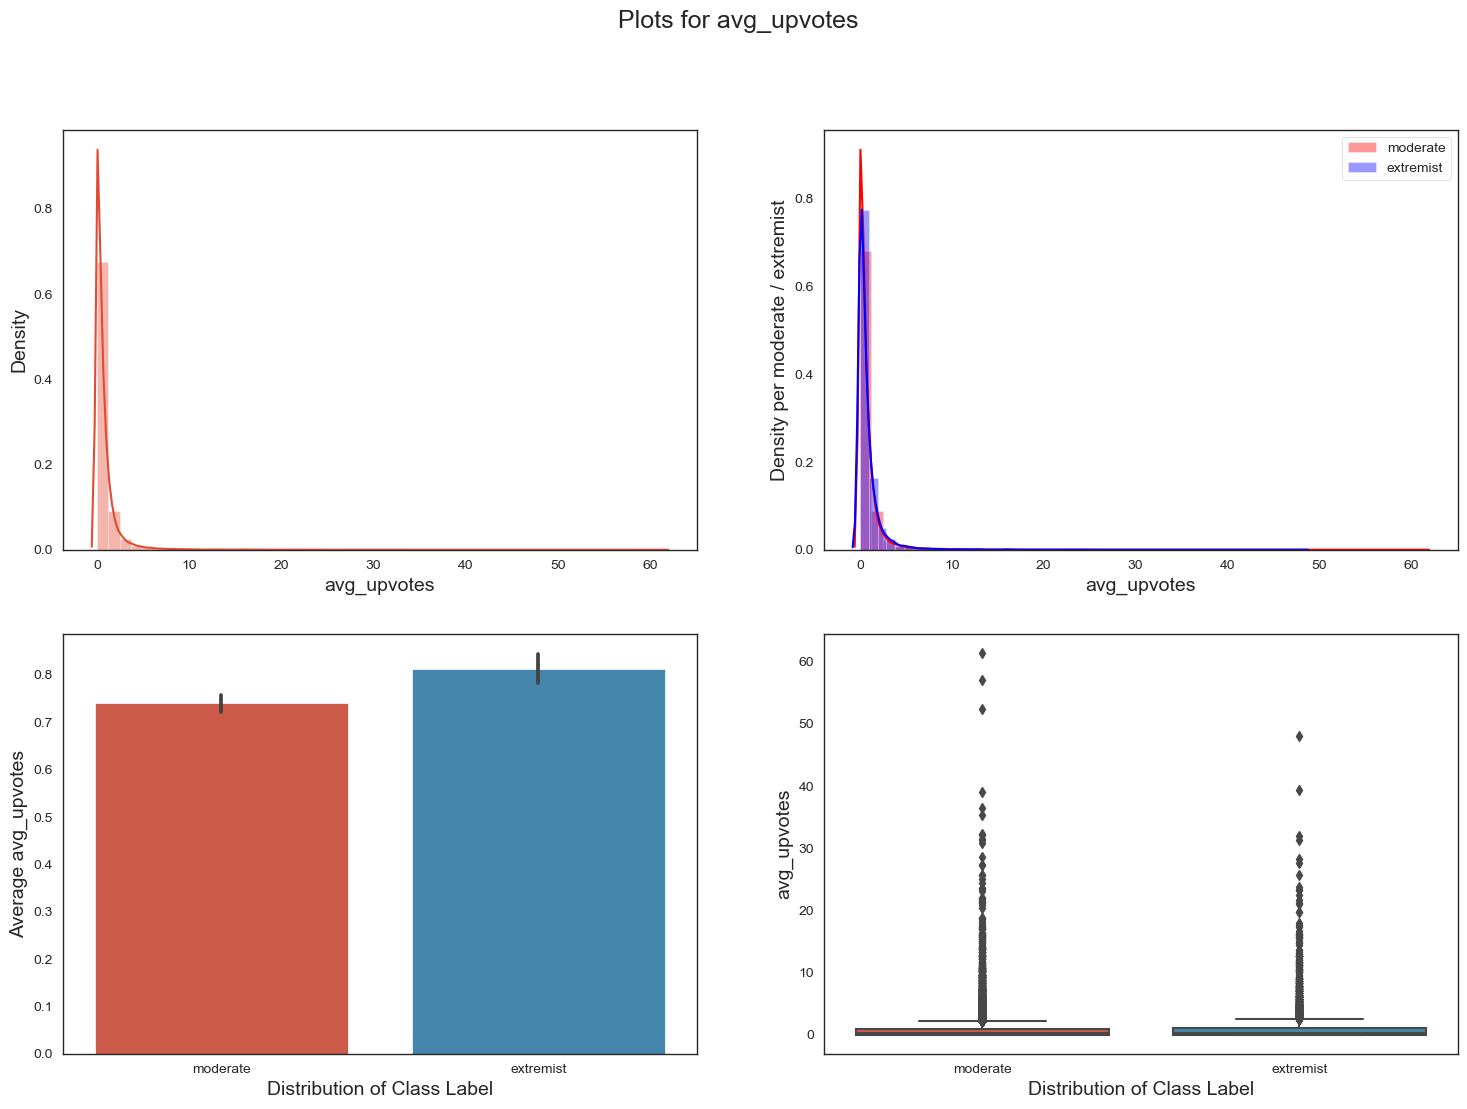

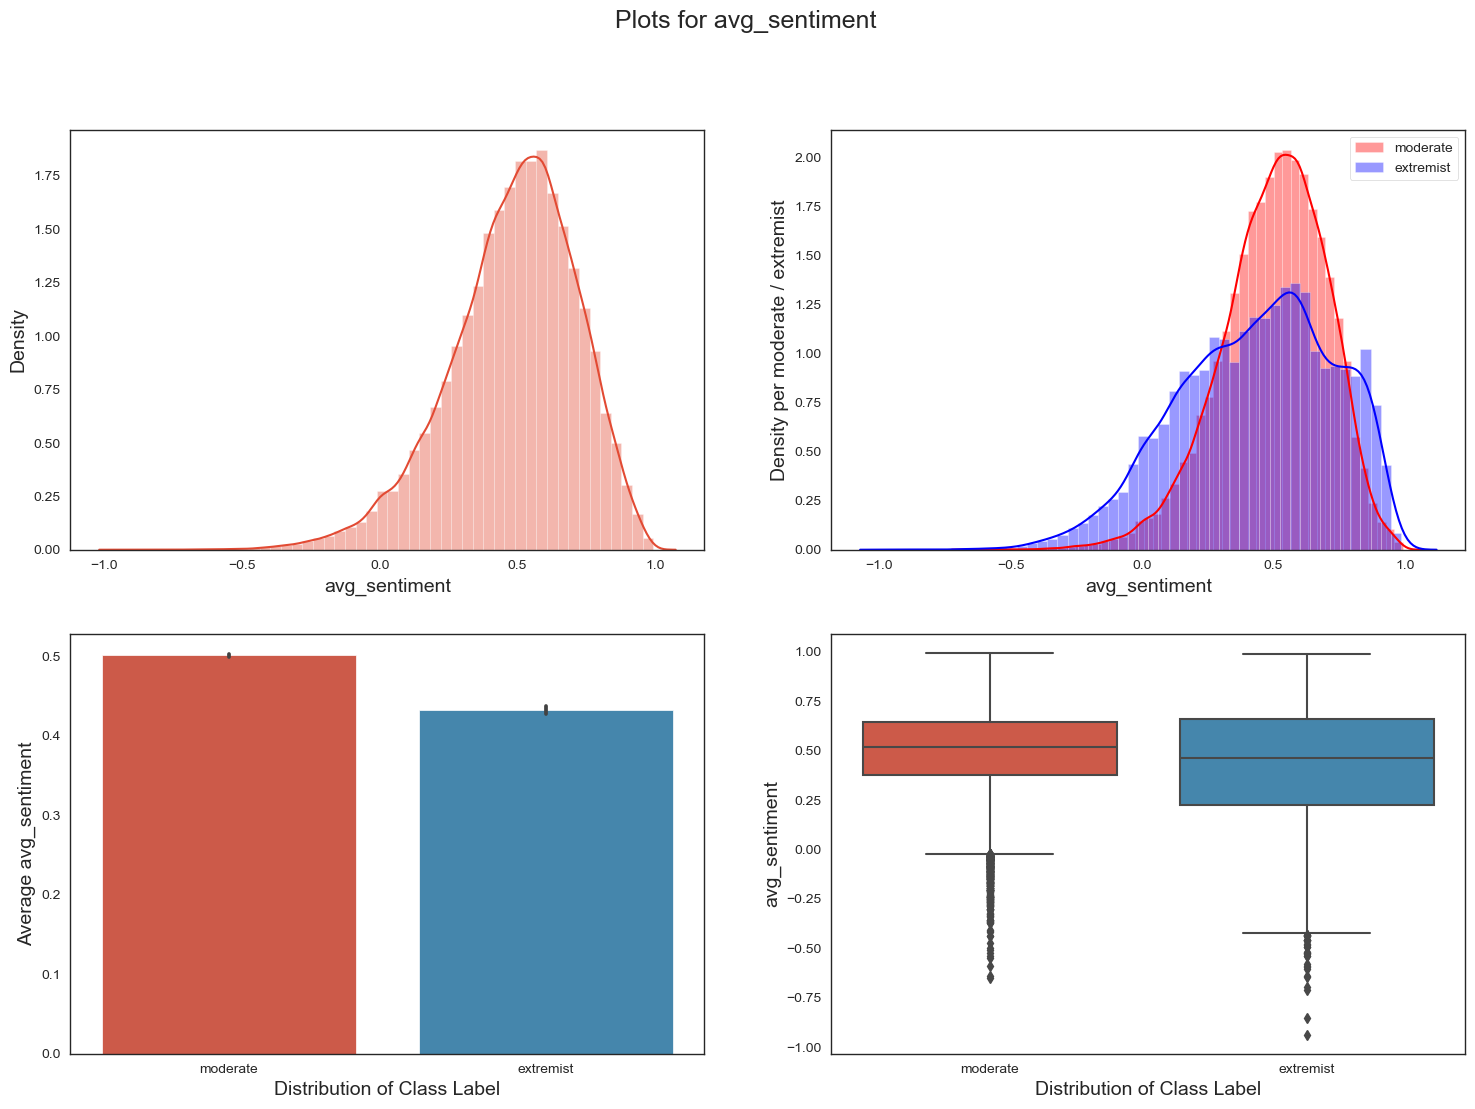

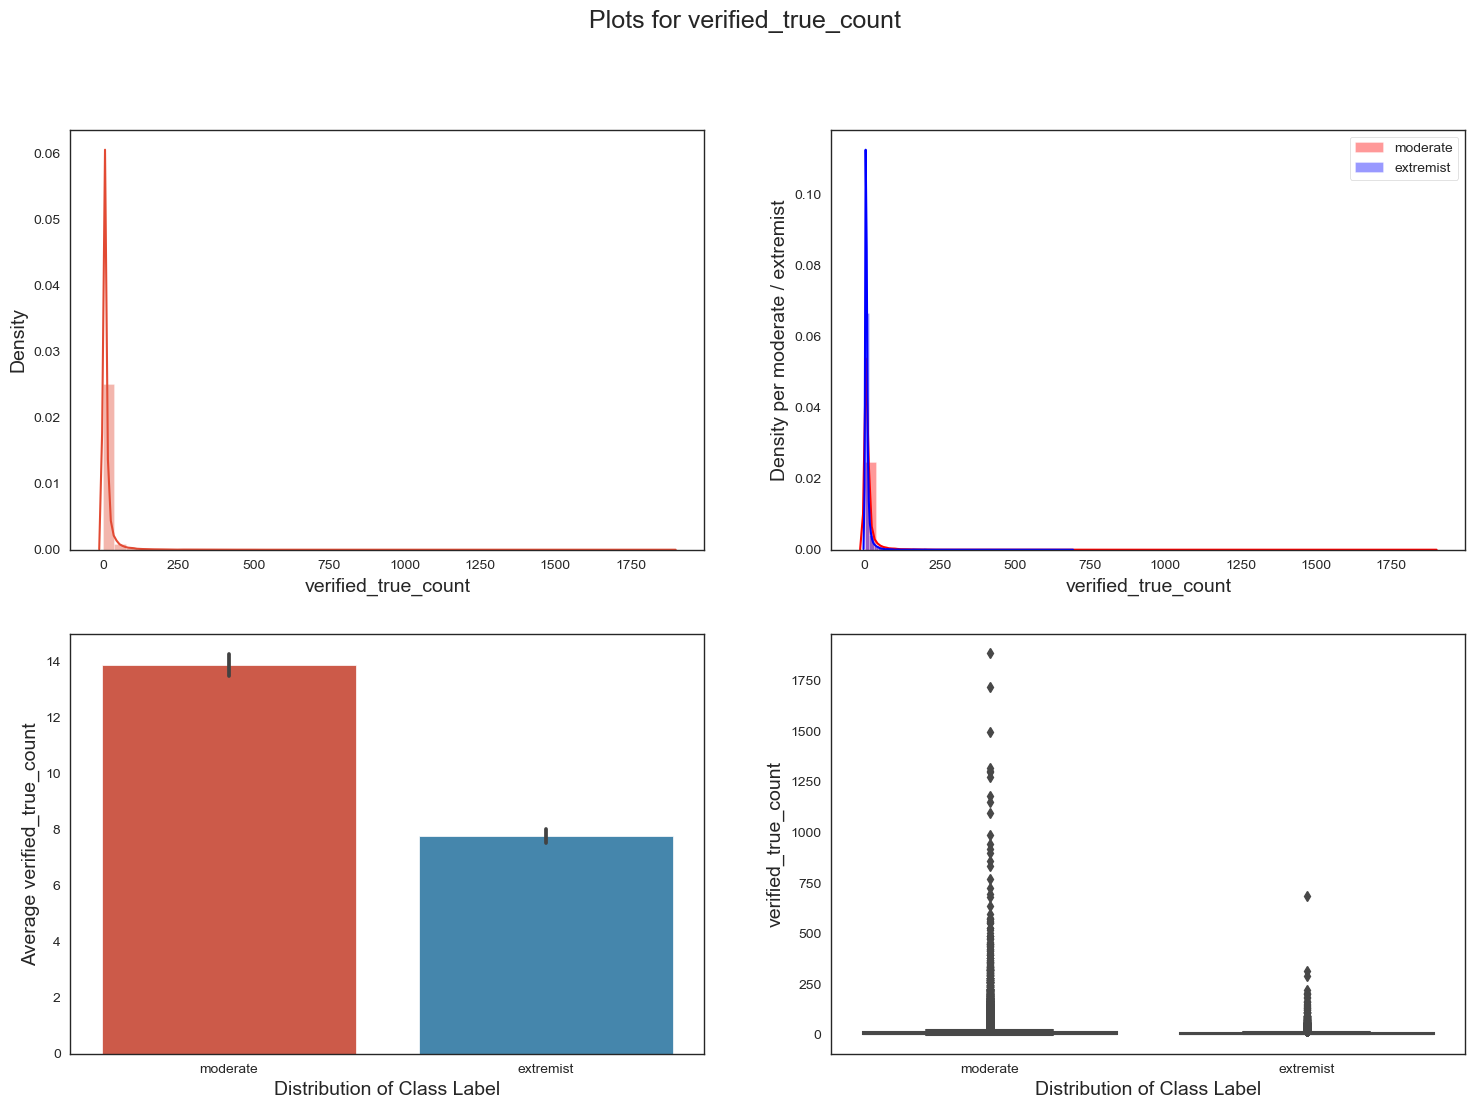

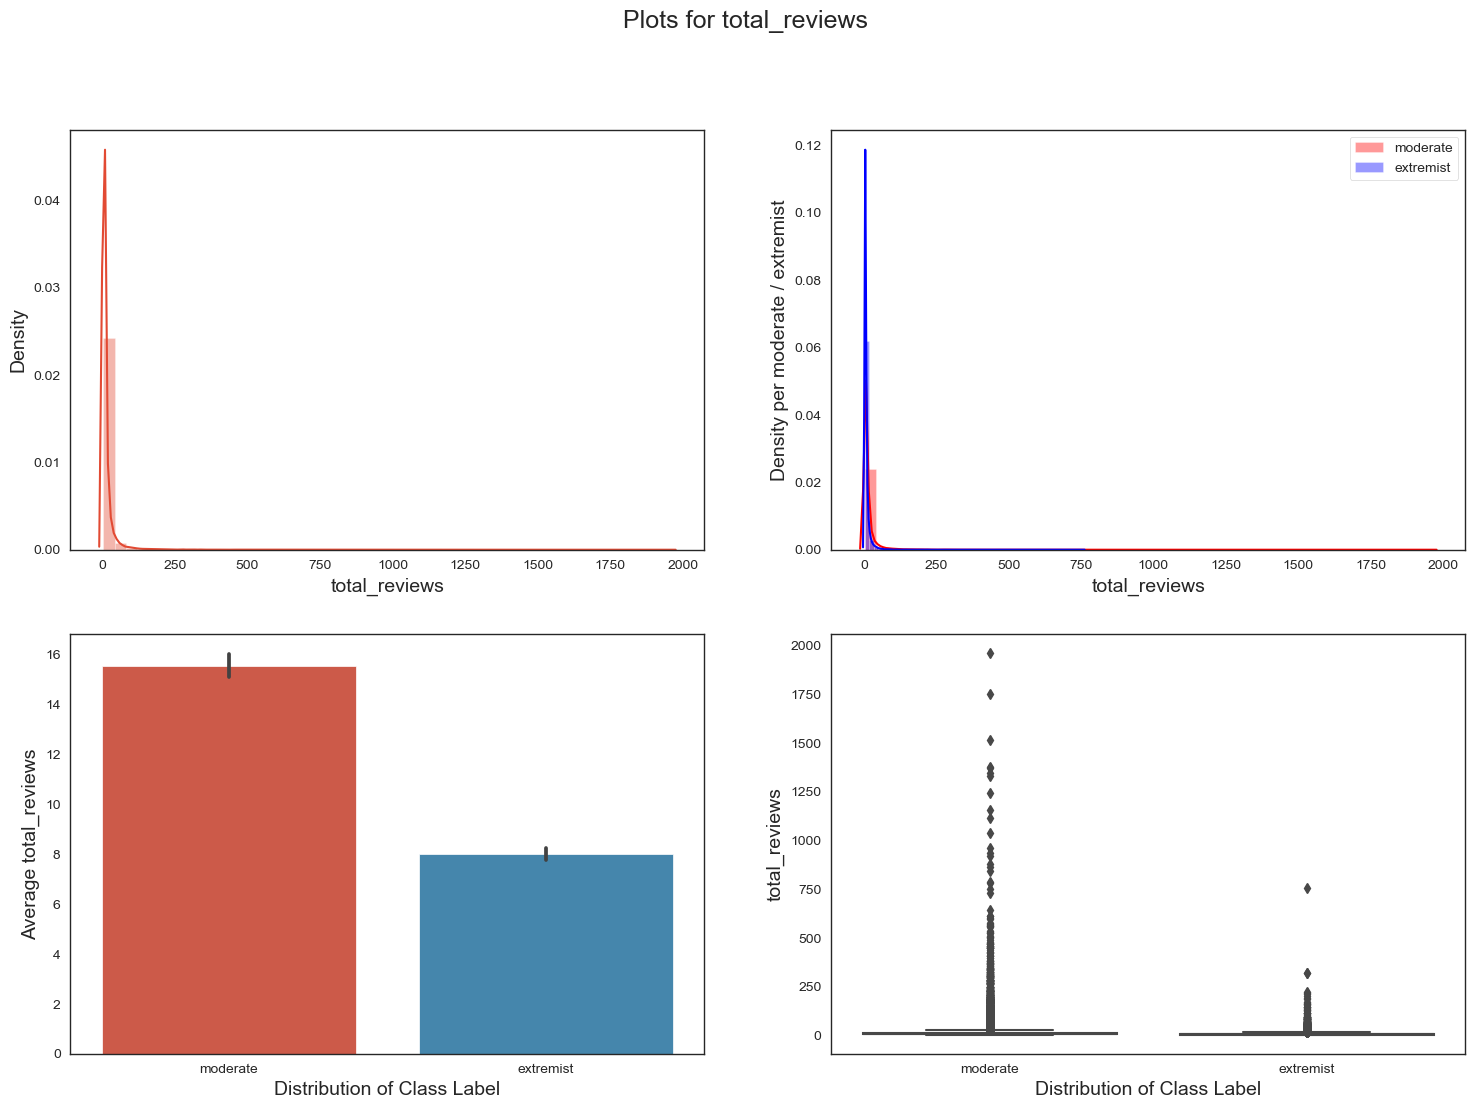

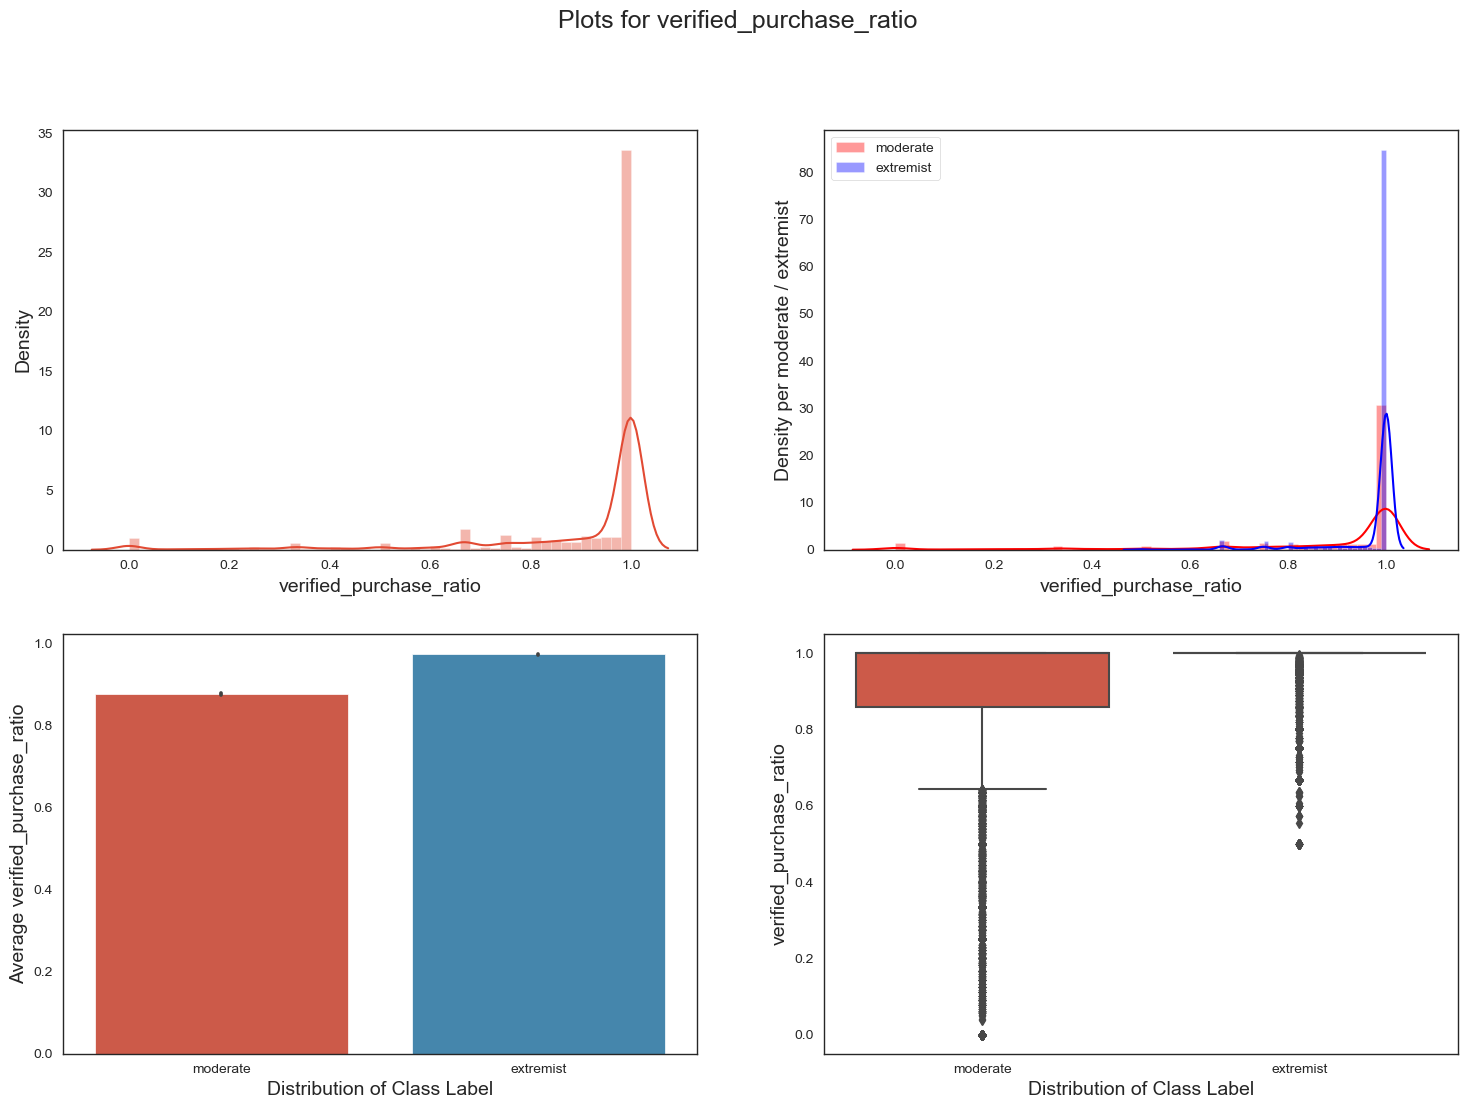

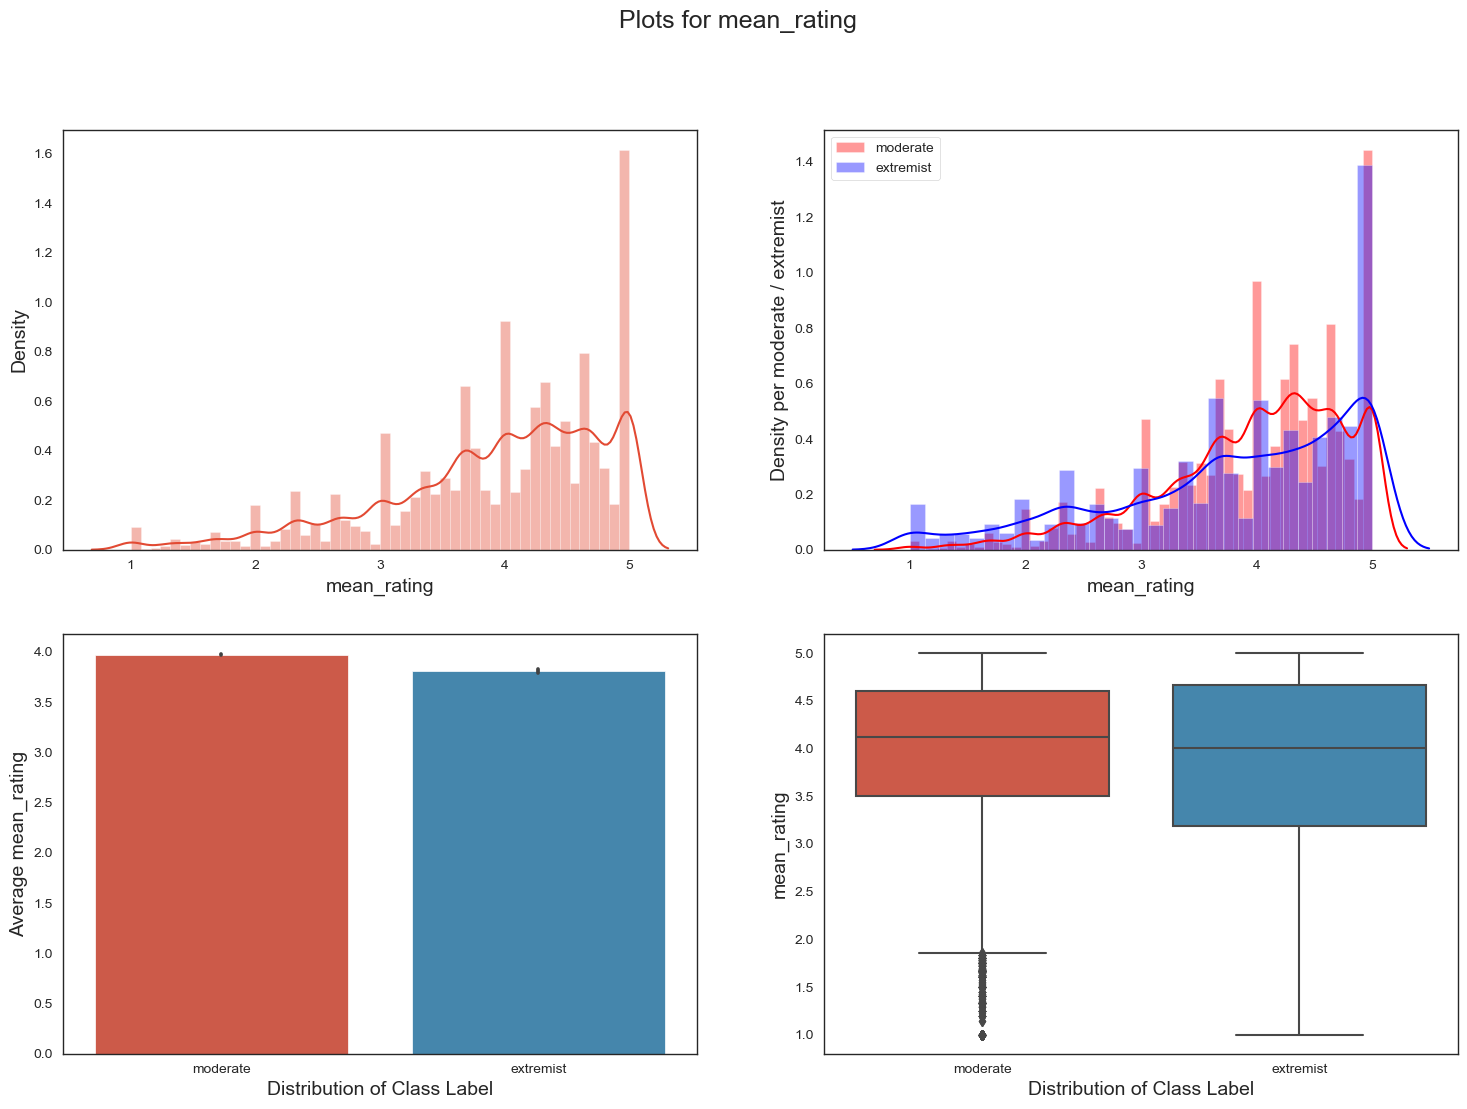

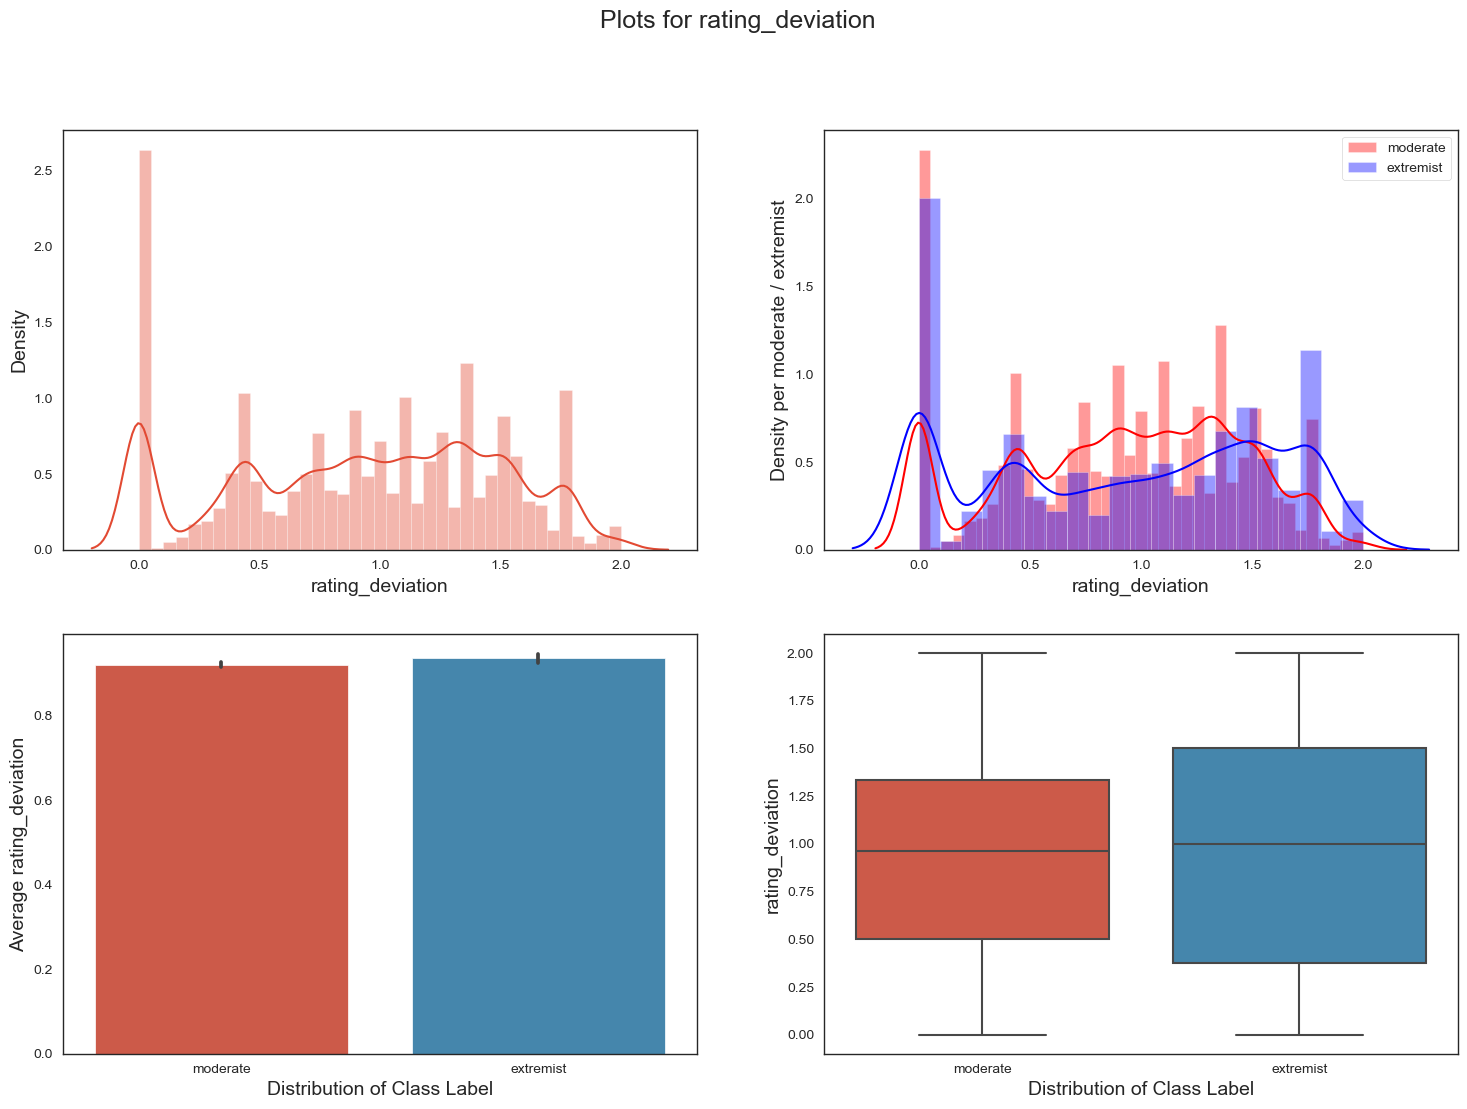

In [15]:
# Plotting Numeric Features
plot_numeric(data, num, 'majority_extremist')

# defining input and output features as X and y respectively

In [16]:
# Separate features and target
X = data.drop(columns=['majority_extremist','parent_asin','total_reviews','review_count'])
y = data['majority_extremist']


In [17]:

Counter(y)

Counter({'moderate': 33645, 'extremist': 11480})

# encoding target features using LabelEncoder 

In [18]:



# Encode string labels to binary
encoder = LabelEncoder()
y = encoder.fit_transform(y) 

In [19]:
Counter(y)

Counter({1: 33645, 0: 11480})

# splitting data into train and test

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# data balancing using SMOTEENN

In [21]:

# Check the class distribution after resampling
print("Original training set class distribution:", Counter(y_train))
# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

# Check the class distribution after resampling

print("Resampled training set class distribution:", Counter(y_train))


Original training set class distribution: Counter({1: 26916, 0: 9184})
Resampled training set class distribution: Counter({0: 16744, 1: 10332})


# scaling input features of both train and test using StandardScaler

In [22]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# initialization and training of models

In [23]:
# --- Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

# --- Logistic Regression ---
lr = LogisticRegression(random_state=42, max_iter=300)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# --- Bagging Classifier ---
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)
y_prob_bagging = bagging.predict_proba(X_test)[:, 1]

# --- XGBoost ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# --- SVM ---
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]

# --- MLP ---
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

# --- Random Forest---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]




# evaluation function for models evaluation

In [24]:
# --- Evaluation function ---
def evaluate_model(y_test, y_pred, y_prob, title):
    print(f"Classification Report for {title}:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {title}:")
    print(cm)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()


# evaluation of decision tree on test data

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.38      0.61      0.47      2296
           1       0.83      0.66      0.74      6729

    accuracy                           0.65      9025
   macro avg       0.61      0.63      0.60      9025
weighted avg       0.72      0.65      0.67      9025

Confusion Matrix for Decision Tree:
[[1398  898]
 [2284 4445]]


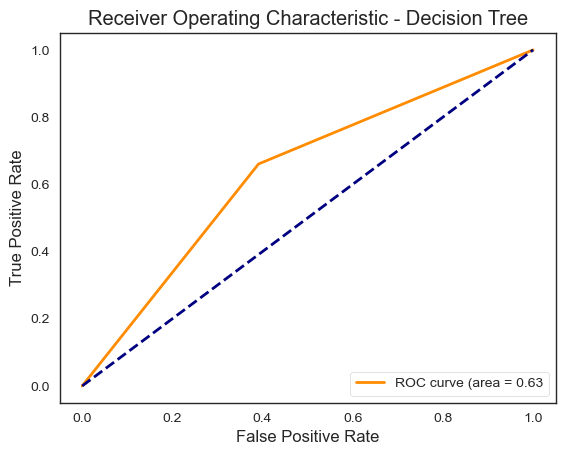

In [25]:
evaluate_model(y_test, y_pred_dt, y_prob_dt, "Decision Tree")




# evaluation of Logistic Regression on test data

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.34      0.86      0.48      2296
           1       0.90      0.42      0.58      6729

    accuracy                           0.53      9025
   macro avg       0.62      0.64      0.53      9025
weighted avg       0.76      0.53      0.55      9025

Confusion Matrix for Logistic Regression:
[[1974  322]
 [3875 2854]]


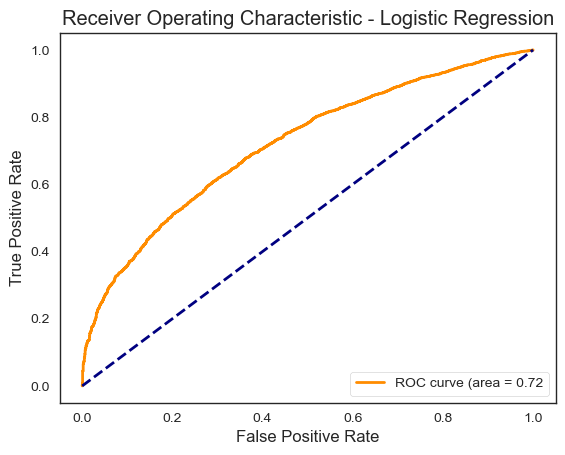

In [26]:
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")


# evaluation of SVM on test data

Classification Report for SVM :
              precision    recall  f1-score   support

           0       0.36      0.86      0.51      2296
           1       0.91      0.48      0.63      6729

    accuracy                           0.58      9025
   macro avg       0.64      0.67      0.57      9025
weighted avg       0.77      0.58      0.60      9025

Confusion Matrix for SVM :
[[1982  314]
 [3495 3234]]


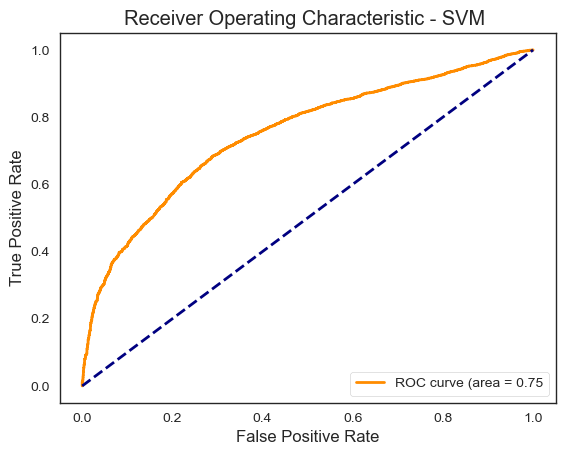

In [29]:
evaluate_model(y_test, y_pred_svm, y_prob_svm, "SVM ")


# evaluation of Bagging Classifier on test data

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.41      0.72      0.52      2296
           1       0.87      0.64      0.74      6729

    accuracy                           0.66      9025
   macro avg       0.64      0.68      0.63      9025
weighted avg       0.75      0.66      0.68      9025

Confusion Matrix for Bagging Classifier:
[[1662  634]
 [2436 4293]]


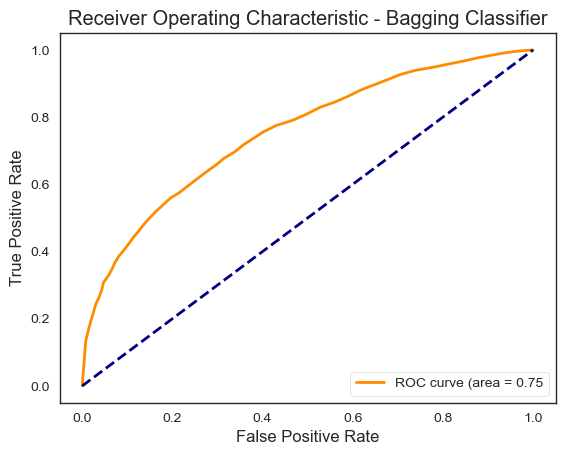

In [27]:
evaluate_model(y_test, y_pred_bagging, y_prob_bagging, "Bagging Classifier")


# evaluation of XGBoost on test data

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.44      0.69      0.54      2296
           1       0.87      0.70      0.78      6729

    accuracy                           0.70      9025
   macro avg       0.66      0.70      0.66      9025
weighted avg       0.76      0.70      0.72      9025

Confusion Matrix for XGBoost:
[[1584  712]
 [2000 4729]]


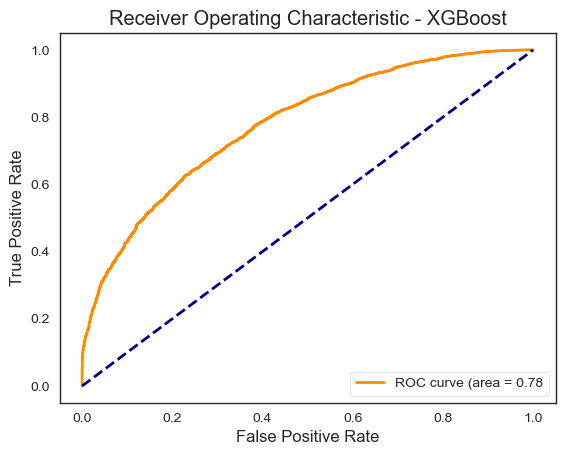

In [28]:
evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")


# evaluation of MLP classifier on test data

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.37      0.75      0.50      2296
           1       0.87      0.57      0.69      6729

    accuracy                           0.62      9025
   macro avg       0.62      0.66      0.60      9025
weighted avg       0.74      0.62      0.64      9025

Confusion Matrix for MLP:
[[1714  582]
 [2865 3864]]


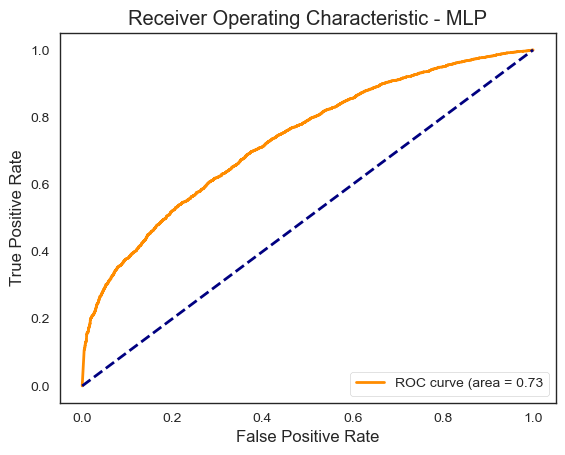

In [30]:
evaluate_model(y_test, y_pred_mlp, y_prob_mlp, "MLP")


# evaluation of Random Forest classifier on test data

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.42      0.75      0.54      2296
           1       0.88      0.64      0.74      6729

    accuracy                           0.67      9025
   macro avg       0.65      0.70      0.64      9025
weighted avg       0.76      0.67      0.69      9025

Confusion Matrix for Random Forest:
[[1732  564]
 [2436 4293]]


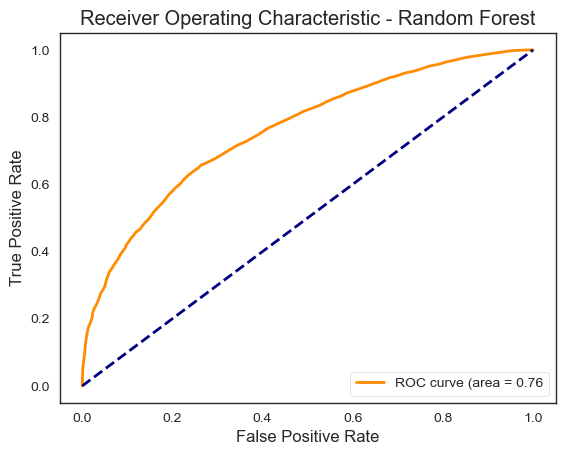

In [31]:
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# feature importance of xgb

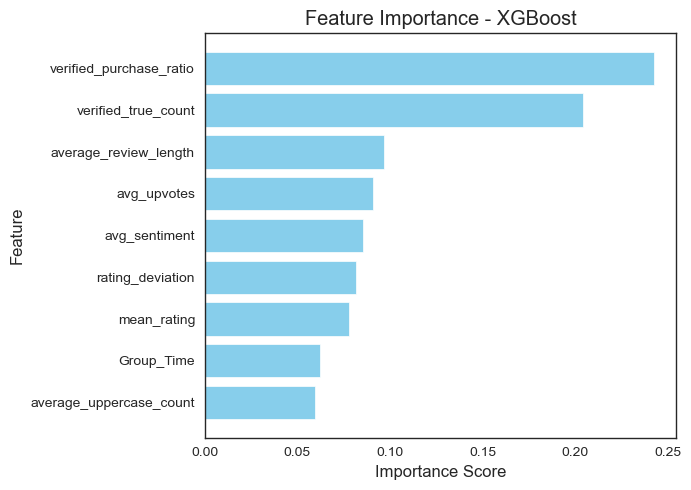

In [32]:
# Map feature importances to column names
feature_importances = pd.DataFrame({
    'Feature': X.columns,  # Original column names
    'Importance': xgb.feature_importances_  # Feature importances from the model
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(7, 5))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

# saving best model, scaler and encoder

In [33]:


pickle.dump(xgb, open('xgb.pkl','wb'))

In [34]:
# Save the label encoders using pickle
with open('scaler.pkl', 'wb') as f1:
    pickle.dump(scaler, f1)

In [35]:
# Save the encoder to a file using pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)